# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Test-Mahalanobis-classifier" data-toc-modified-id="Test-Mahalanobis-classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test Mahalanobis classifier</a></div><div class="lev2 toc-item"><a href="#Create-dataset" data-toc-modified-id="Create-dataset-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Create dataset</a></div><div class="lev3 toc-item"><a href="#Add-increasing-noise-per-label" data-toc-modified-id="Add-increasing-noise-per-label-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Add increasing noise per label</a></div><div class="lev1 toc-item"><a href="#Comparing-covariance-estimators" data-toc-modified-id="Comparing-covariance-estimators-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Comparing covariance estimators</a></div><div class="lev1 toc-item"><a href="#Compare-beginning-and-changepoint" data-toc-modified-id="Compare-beginning-and-changepoint-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compare beginning and changepoint</a></div><div class="lev2 toc-item"><a href="#Show-some-precision-matrices" data-toc-modified-id="Show-some-precision-matrices-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Show some precision matrices</a></div><div class="lev2 toc-item"><a href="#Distance-matrices" data-toc-modified-id="Distance-matrices-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Distance matrices</a></div><div class="lev3 toc-item"><a href="#Target-x-Real" data-toc-modified-id="Target-x-Real-321"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Target x Real</a></div><div class="lev3 toc-item"><a href="#Simmetrized" data-toc-modified-id="Simmetrized-322"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Simmetrized</a></div>

In [1]:
from sklearn.model_selection import GroupShuffleSplit
import sys
sys.path.append('/home/tevo/Documents/UFABC/Spikes')
sys.path.append('/home/tevo/Documents/UFABC/SingleUnit Spike Learning/src/models/')
sys.path.append('/home/tevo/Documents/UFABC/SingleUnit Spike Learning/spikelearn/models')
import os
os.chdir('/home/tevo/Documents/UFABC/Spikes')
from spikeHelper.loadSpike import Rat
import numpy as np
import pandas as pd
from mahalanobis import MahalanobisClassifier

# Test Mahalanobis classifier

## Create dataset

In [396]:
A = np.eye(10)*np.random.randint(13,17,10)
B = A+12*np.random.rand(10,10)
B = B+B.transpose()
mu = np.random.randint(13,17,10)
Xk = np.random.multivariate_normal(mu,B , 7000); yk = np.random.randint(0,7,7000)
precB = np.linalg.inv(B)

### Add increasing noise per label

In [404]:
for i in range(7):
    Xk[yk==i] = Xk[yk==i] + 2*i*np.random.rand(*Xk[yk==i].shape)

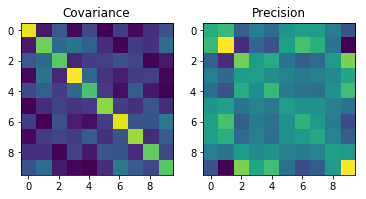

In [407]:
plt.subplot(1,2,1)
plt.imshow(B); plt.title('Covariance')
plt.subplot(1,2,2)
plt.imshow(precB); plt.title('Precision');

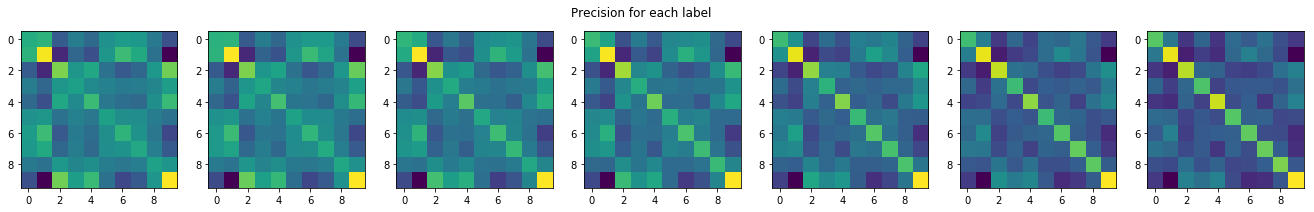

In [411]:
clf = MahalanobisClassifier(classes=np.arange(7), estimator='oas', shared_cov=False, assume_centered=False)
mah = clf.fit(Xk,yk)
plt.figure(figsize=(23,3))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(mah.precision_[i])
    plt.suptitle('Precision for each label')

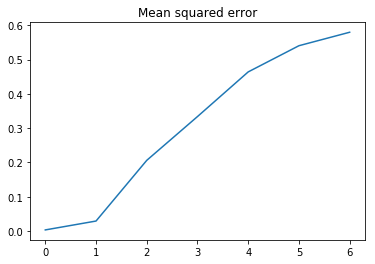

In [414]:
plt.title('Mean squared error')
plt.plot([((precB-mah.precision_[i])**2).sum() for i in range(7)]);

Text(33,0.5,'Target label')

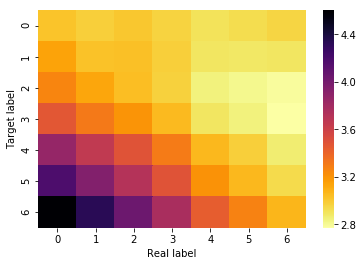

In [410]:
sns.heatmap(np.array([mah.transform(Xk[yk==yi]).mean(axis=0) for yi in range(7)]), cmap='inferno_r')
plt.xlabel('Real label')
plt.ylabel('Target label')

# Comparing covariance estimators

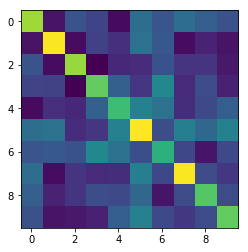

In [123]:
A = np.eye(10)*np.random.randint(13,17,10)
B = A+12*np.random.rand(10,10)
B = B+B.transpose()
mu = np.random.randint(13,17,10)
k = np.random.multivariate_normal(mu,B , 1000)
plt.imshow(B)

In [ ]:
ESTIMATORS = ['OAS', 'LedoitWolf', 'Empirical']

distances = pd.DataFrame()
similarity_matrices = pd.DataFrame()
covariances = pd.DataFrame()


sh = GroupShuffleSplit(50, .5,.5)

for rat_number in [7,8,9,10]:
    r = Rat(rat_number, 20,100)
    r.selecTrials(dict(minDuration=1500, maxDuration=2500))
    r.selecTimes(-500,1500)
    classes = np.unique(r.y)

    for estimator in ESTIMATORS:
        for cov_sharing in [0,1]:
            clf = MahalanobisClassifier(classes=classes, estimator=estimator, shared_cov=cov_sharing)

            for half1_idx, half2_idx in sh.split(r.X, r.y, r.trial):
                dists1 = clf.fit(r.X[half1_idx], r.y[half1_idx]).transform(r.X[half2_idx])
                dists2 = clf.fit(r.X[half2_idx], r.y[half2_idx]).transform(r.X[half1_idx])

                res = pd.DataFrame(np.vstack((dists1,dists2)), 
                                   index=pd.Index(np.hstack((r.y[half2_idx], r.y[half1_idx])),name='Real Time'), 
                                   columns=pd.Index(classes, name='Target time'))
                res['Trial'] = np.hstack( ( r.trial[half2_idx], r.trial[half1_idx] ) )
                res['Covariance Estimator'] = estimator
                res['Covariance Sharing'] = cov_sharing
                res['Rat'] = rat_number
                distances = distances.append(res)

                if cov_sharing:
                    cov = pd.DataFrame({'Covariances': [clf.precision_[0]]},index=pd.Index(['Full'],name='Time')).reset_index()
                else:
                    cov = pd.DataFrame({k:[clf.precision_[k]] for k in clf.precision_.keys()},index=['Covariances'],columns=pd.Index(classes,name='Time')).transpose().reset_index()
                cov['Covariance Estimator'] = estimator
                cov['Covariance Sharing'] = cov_sharing
                cov['Rat'] = rat_number
                covariances = covariances.append(cov)

            sim = distances.reset_index().drop('Trial',axis=1).groupby(['Covariance Estimator','Covariance Sharing']).get_group((estimator, cov_sharing)).groupby('Real Time').agg(np.mean)
            sim['Covariance Estimator'] = estimator
            sim['Covariance Sharing'] = cov_sharing
            sim['Rat'] = rat_number
            similarity_matrices = similarity_matrices.append(sim)

In [ ]:
import pickle
pickle.dump(covariances, open('precisions.pickle', 'wb'))
pickle.dump(similarity_matrices, open('similarity_matrices.pickle', 'wb'))
pickle.dump(distances, open('distances.pickle', 'wb'))


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

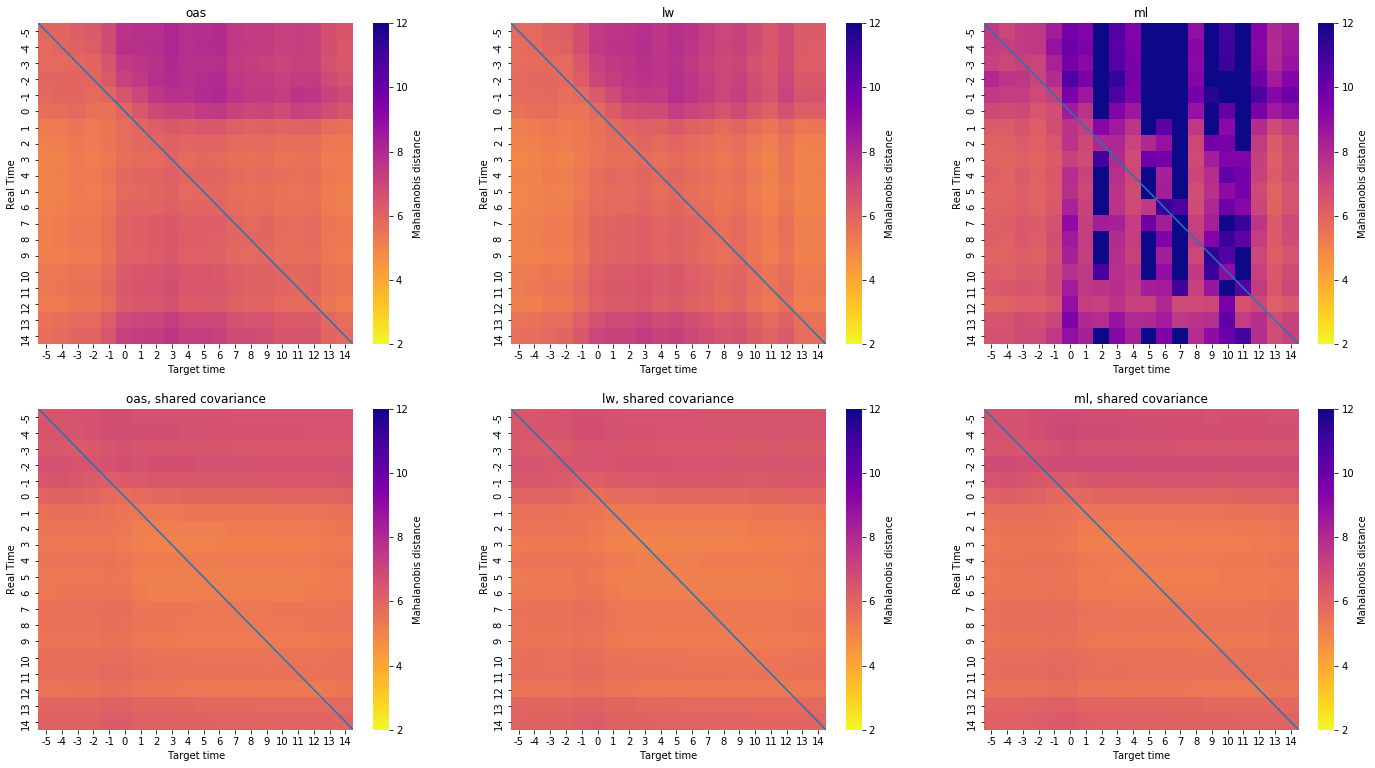

In [201]:
plt.figure(figsize=(24,13))
for i, estimator in enumerate(['oas', 'lw', 'ml']):
    for j, cov_sharing in enumerate([0, 1]):
        plt.subplot(2,3,i+1+3*j)
        sim = all_res[estimator][cov_sharing].reset_index().groupby('Real Time').agg(np.mean)
        sns.heatmap(sim, cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'}, vmin=2,vmax=12)
        plt.plot([0,20],[0,20])
        plt.title(estimator + cov_sharing*', shared covariance')

# Compare beginning and changepoint

In [11]:
CPs = {7:157, 8:314, 9:176, 10:119}
iti_best = {7:400, 8:550, 9:300, 10:400}

classes= np.arange(-5,15)
n_splits = 50

distances = pd.DataFrame()
sim_matrices = pd.DataFrame()
precisions = pd.DataFrame()
for rat_number in [7, 8, 9, 10]:
    ri = Rat(rat_number, 100,100)
    ri.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMax=CPs[rat_number]))
    ri.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    rf = Rat(rat_number, 100,100)
    rf.selecTrials(dict(minDuration=1500, maxDuration=2500, trialMin=CPs[rat_number], trialMax=iti_best[rat_number]))
    rf.selecTimes(-500,1500, z_transform='basemean_fullstd')
    
    size = min(np.unique(ri.trial).shape[0],np.unique(rf.trial).shape[0])
    s1, s2 = size//2, size - size//2
    
    sh = GroupShuffleSplit(n_splits, s1, s2)
    for label, r in [('Before', ri), ('After', rf)]:
        for half1_idx, half2_idx in sh.split(r.X, r.y, r.trial):
#             print(np.unique(r.trial[half1_idx]))
#             print(np.unique(r.trial[half2_idx]))
#             print('--------------------------')
            clf = MahalanobisClassifier(classes=classes, estimator='oas', shared_cov=False, assume_centered=True)
            dists1 = clf.fit(r.X[half1_idx], r.y[half1_idx]).transform(r.X[half2_idx])
            clf = MahalanobisClassifier(classes=classes, estimator='oas', shared_cov=False, assume_centered=True)
            dists2 = clf.fit(r.X[half2_idx], r.y[half2_idx]).transform(r.X[half1_idx])

            res = pd.DataFrame(np.vstack((dists1,dists2)), 
                               index=pd.Index(np.hstack((r.y[half2_idx], r.y[half1_idx])),name='Real Time'), 
                               columns=pd.Index(classes, name='Target time'))
            res['Trial'] = np.hstack( ( r.trial[half2_idx], r.trial[half1_idx] ) )
            res['Rat'] = rat_number
            res['Label'] = label
            res['halftrials'] = s1
            distances = distances.append(res)

            cov_inv = pd.DataFrame({k:[clf.precision_[k]] for k in clf.precision_.keys()},index=['Precision'],columns=pd.Index(classes,name='Time')).transpose().reset_index()
            cov_inv['Rat'] = rat_number
            cov_inv['Label'] = label
            precisions = precisions.append(cov_inv)

sim_matrices = distances.reset_index().groupby(['Real Time', 'Rat', 'Label']).agg(np.mean)

[  1.66317565e+00   1.58772917e+01   1.52397473e+00   3.54445012e+00
   6.07684309e+01   3.15121331e+01   1.96726258e+00   2.47768231e+00
   4.12946186e+00   4.02540099e+00   5.04718181e+00   1.62068841e+00
   4.34545920e+00   3.93945242e+00   1.00000000e-02   1.54577221e+00
   5.27834497e+00   9.15868030e+00   1.23747746e+00   8.71952352e+00
   9.89712714e-01   1.25582032e+00   3.48838582e+00   1.00613189e+00
   1.12144142e+01   4.24115769e+01   1.00000000e-02   1.79996251e+00
   6.19976839e-01]
[  1.99696124   8.25514786   2.20195182   9.30433219   1.73976079
   9.2155763    2.4006587    1.99258289   3.72438879   5.94131275
   4.74375215   1.3521403    4.61163735   0.41420192   3.93896787
   3.78008712  12.16936943   1.72333935   3.49341351  12.10773235
  11.13695754   3.22375017   6.03534189   1.40661479   1.72697242
   2.98870785   2.29006469   0.4336042    2.31112287]
[ 2.49736187  1.5194037   2.09551099  2.47069709  1.8226306   1.97054532
  2.4864169   3.50022884  2.20674057  2.2

## Show some precision matrices

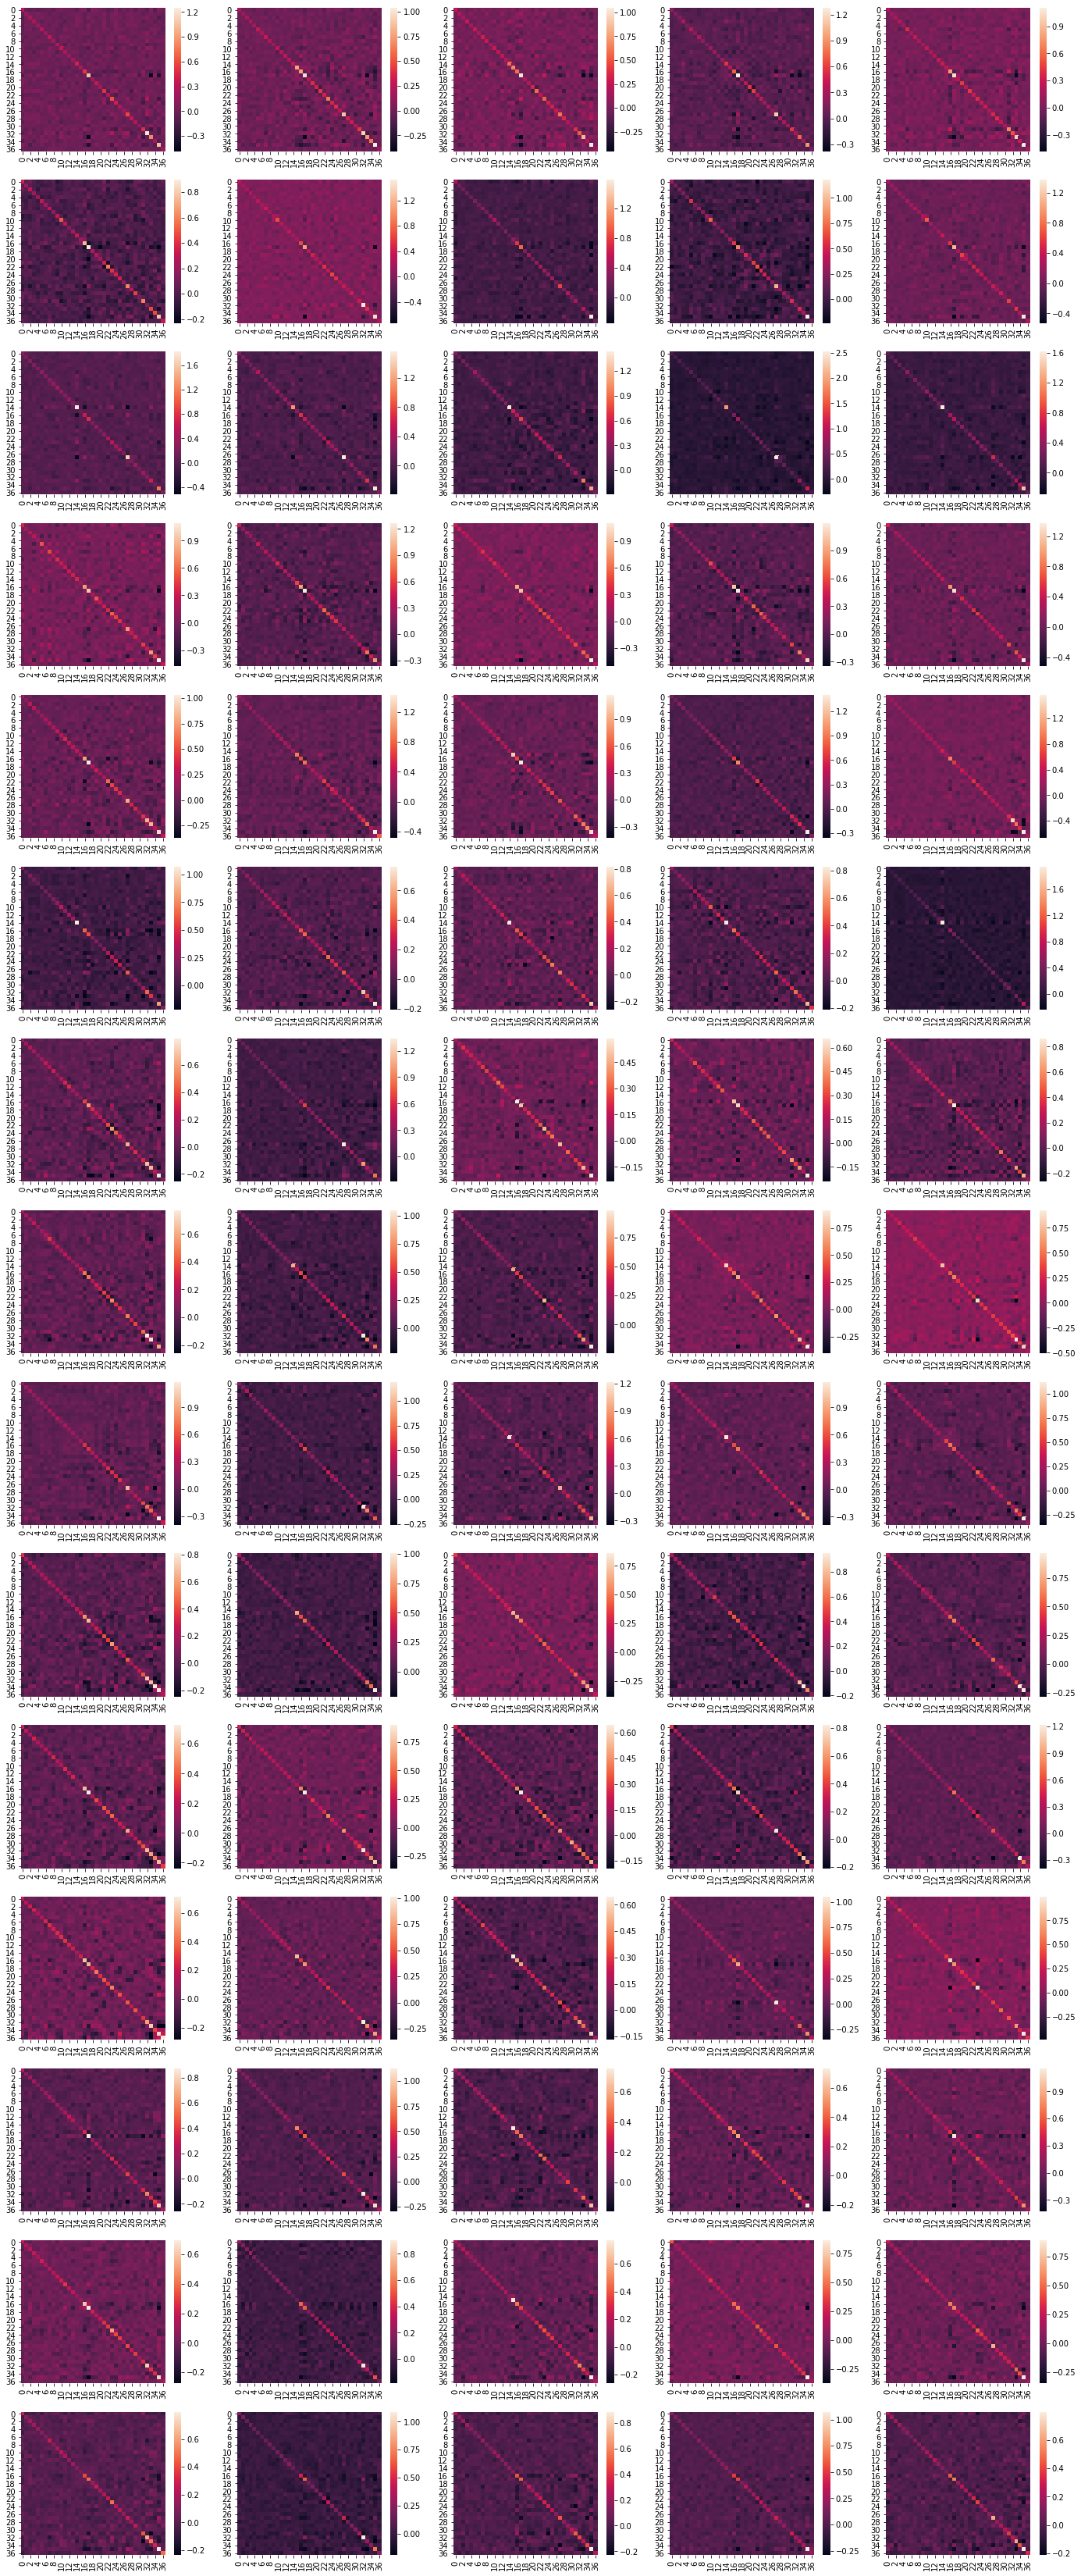

In [441]:
plt.figure(figsize=(24,60))
for i, time in enumerate(classes):
    for j, p in enumerate(precisions.groupby(['Rat','Label', 'Time']).get_group((8,'Before',time)).Precision.values):
        plt.subplot(15,5,j+1+5*i)
        sns.heatmap(p)#, cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'}, vmin=2,vmax=12, ax=ax)

## Distance matrices

In [5]:
def one_sim(rat_number, label):
    return sim_matrices.reset_index().groupby(['Rat', 'Label']).get_group((rat_number, label)).reset_index().drop(['Rat', 'Label','index', 'halftrials','Trial'], axis=1).set_index('Real Time')

### Target x Real

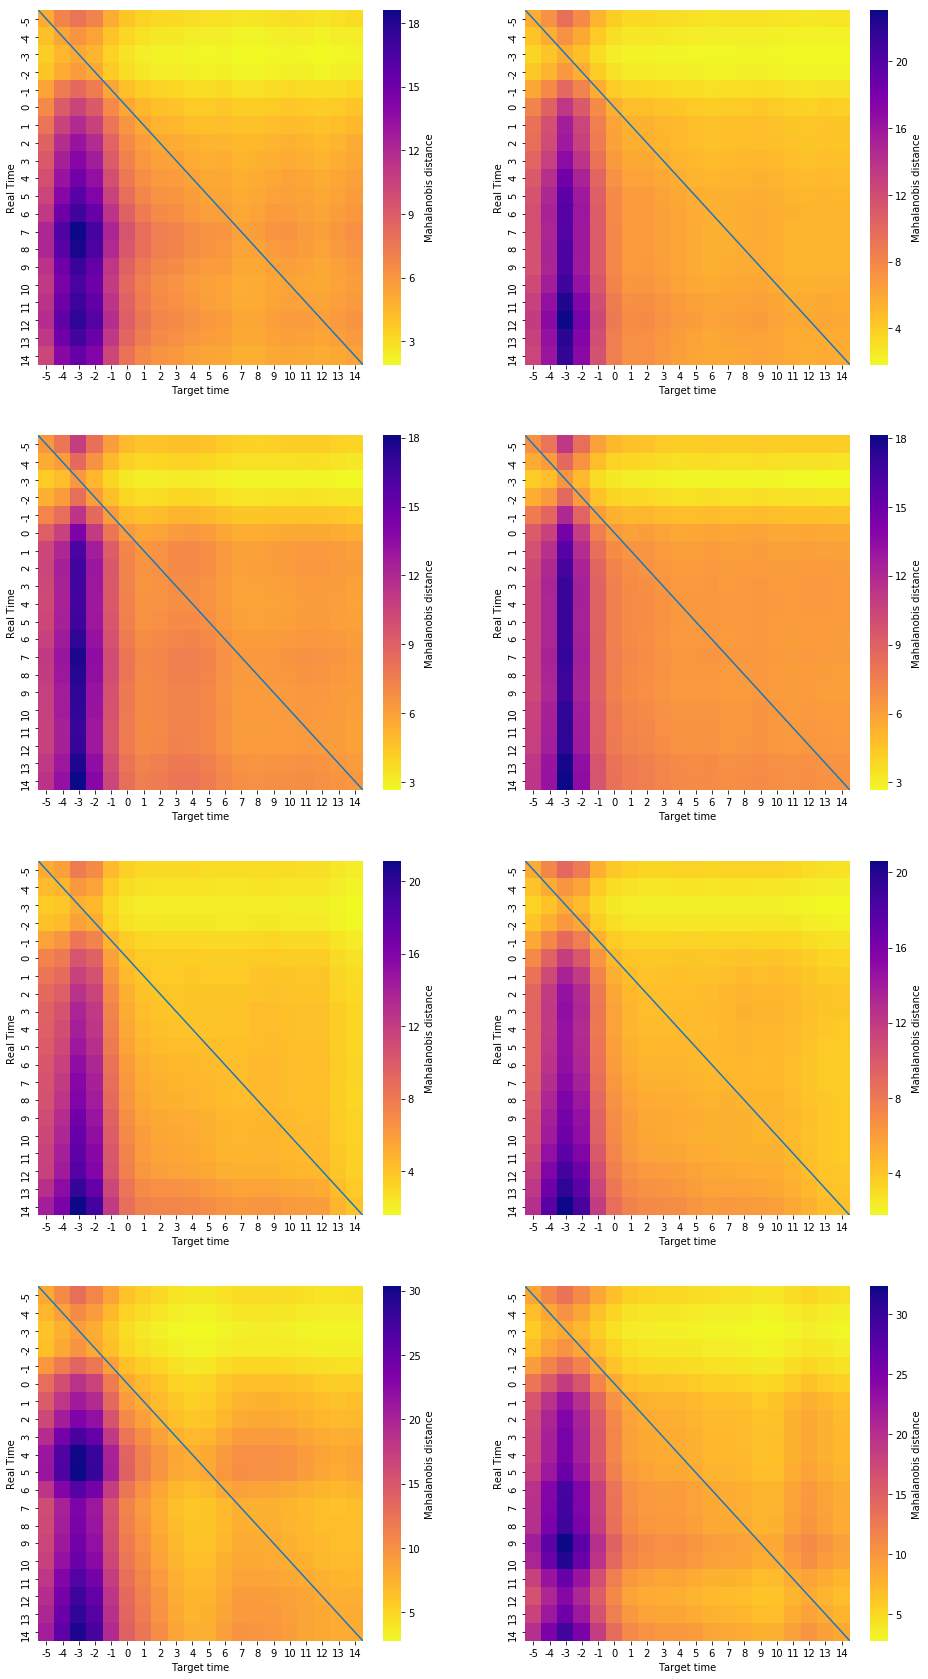

In [12]:
plt.figure(figsize=(16,30))

for j, label in enumerate(['Before', 'After']):
    for i, rat in enumerate([7,8,9,10]):
        ax = plt.subplot(4,2,i*2 + j+1)
        sns.heatmap(one_sim(rat, label), cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'},  ax=ax)
        plt.plot([0,20],[0,20])

### Simmetrized

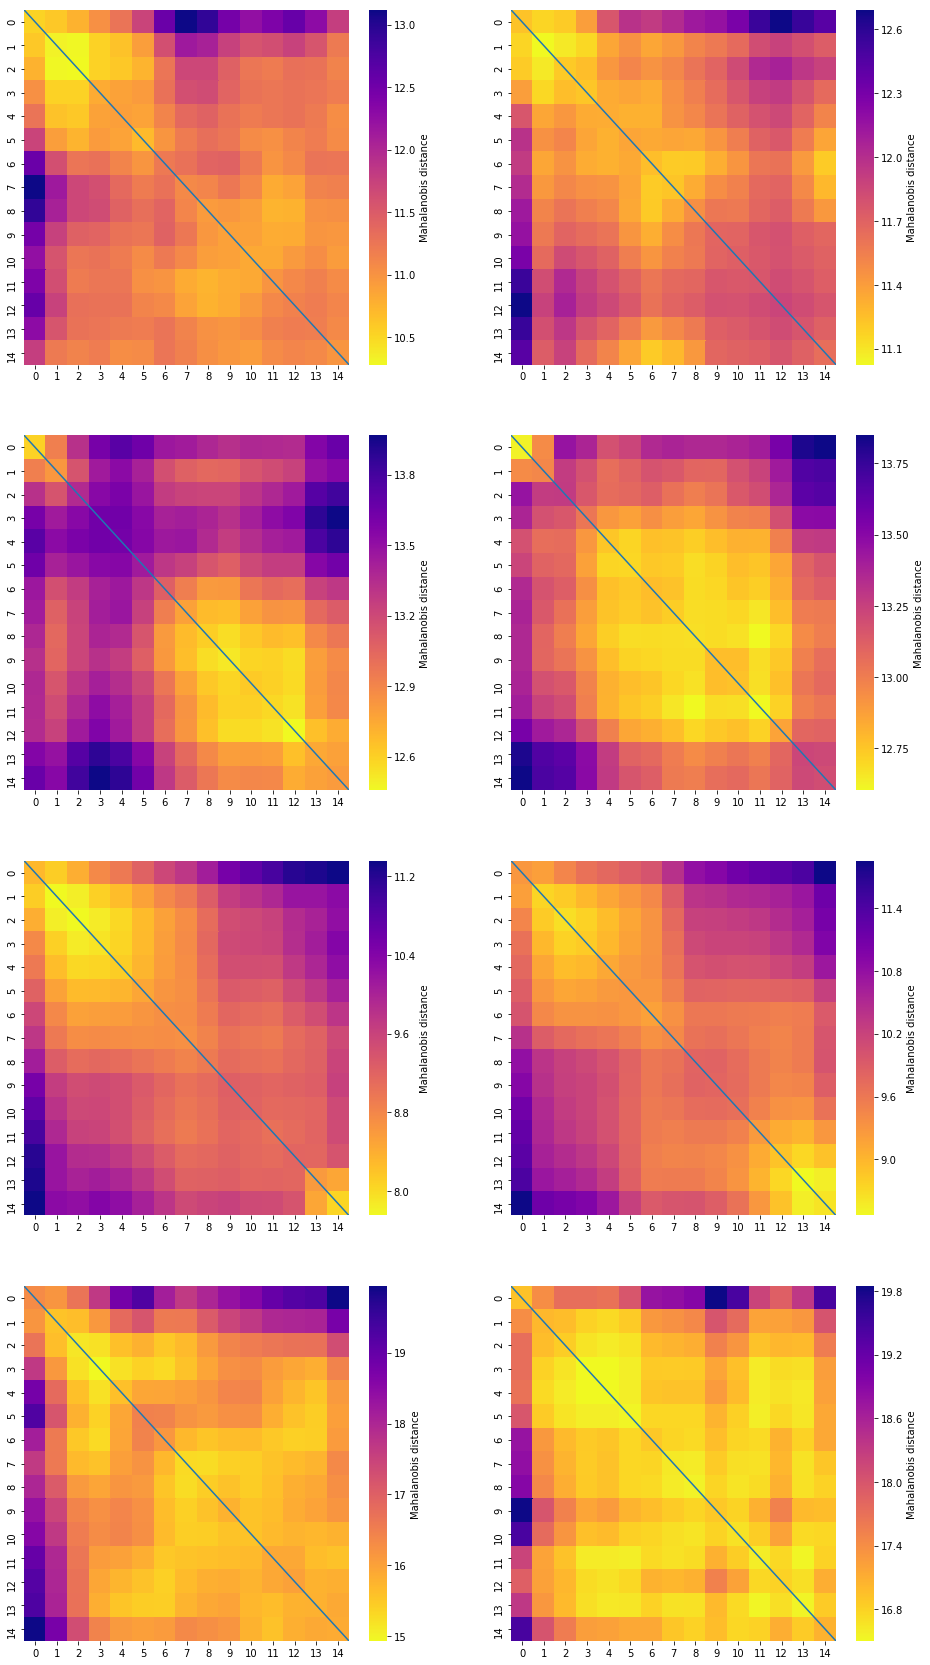

In [13]:
plt.figure(figsize=(16,30))

for j, label in enumerate(['Before', 'After']):
    for i, rat in enumerate([7,8,9,10]):
        ax = plt.subplot(4,2,i*2 + j+1)
        S = one_sim(rat, label).values+ one_sim(rat, label).transpose().values
        sns.heatmap(S[5:,5:], cmap='plasma_r', cbar_kws={'label': 'Mahalanobis distance'}, ax=ax)
        plt.plot([0,20],[0,20])